# My First RNN

Code which trains a recurrent NN to make predictions on points in advance of a time series dataset. It's my first RNN, so go easy on me! 

Written in Tensorflow

In [1]:
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras import optimizers # to choose more advanced optimizers like 'adam'

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

import numpy as np 
from scipy import stats
import random

import os

As is customary, let's define some useful classes

In [2]:
class rn_network(tf.Module):
    def __init__(self, nn_type, units, num_features, num_inputs, name): # Format is (type, neurons, number of output features, number of input featues)
        super(rn_network, self).__init__()
        # Assign the architecture to the RNN instance
        
        if (nn_type==0): # This architecture is probably meant
            self.mynn = tf.keras.models.Sequential([
            # Shape [batch, time, features] => [batch, time, lstm_units]
            tf.keras.layers.LSTM(units, input_shape=(None, num_inputs), return_sequences=False),
            # Shape => [batch, time, features]
            tf.keras.layers.Dense(units=num_features)], name=name)

# This is so that we get live feedback on how well our network is learning at each epoch. Credit to this medium article (https://medium.com/geekculture/how-to-plot-model-loss-while-training-in-tensorflow-9fa1a1875a5_) and to the QPT paper from before

class PlotLearning(tf.keras.callbacks.Callback):
    
    """
    Callback to plot the learning curves of the model during training.
    """
    
    def __init__(self):
        super(PlotLearning,self).__init__()
    
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        print(' Saving current plot of training evolution')
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        # Plotting
        # metrics = [x for x in logs if 'val' not in x]
            
        f, axs = plt.subplots(1, 1, figsize=(5,5))
        clear_output(wait=True)

        axs.plot(range(1, epoch + 2), 
                self.metrics['loss'], 
                label='loss')
        axs.plot(range(1, epoch + 2), 
                self.metrics['val_loss'], 
                label='val_loss')

        axs.legend()
        axs.grid()
            
        model_name = self.model.name
        directory = f'plots/{model_name}'
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        plt.tight_layout()
        plt.savefig(directory + f'/epochs_{epoch}.png')
        
        print('Saved plot of most recent training epoch to disk')
            

Let's look at the folder ... how many files?

In [3]:
direc_name = "Batched Data/OneHourAhead" # yaml worthy
time_steps = 12 # yaml worthy 
sizeOfFiles = len([name for name in os.listdir(f'{direc_name}/.')]) # Global parameter
print(f"Number of files:{sizeOfFiles}")

Number of files:4416


# Experiment 1: 'Basic'

Here, given input data consisting of 12 time steps w/ one hour resolution, we try to predict the Cn^2 value and Fried parameter $N$ hours ahead

**Sub-Experiment #1: One Hour Ahead (Linearly Interpolated Data)**

Our data is being batched externally ... let's load up the csv files and compose a dataset out of that. 

In [4]:
import pandas as pd

# How much should we set aside for training, and how much should we use for testing later?

train_factor = 0.90

num_of_examples = int(sizeOfFiles*train_factor)

# Routine to normalize between 0 and 1 (Following the atmospheric turbulence paper)


def norm_data(x):
    for ii in range(len(x)):
        x[ii] = (x[ii] - np.min(x))/(np.max(x) - np.min(x))
    return x

def loadData(direc_name, time_steps):
    
    total_input = []
    total_output = []
    
    # Files expected
    
    directory_list = [name for name in os.listdir(f'{direc_name}/.')]
    
    
    for ii, name in enumerate(directory_list):
        df = pd.read_csv(f'{direc_name}/{name}')
        
        dataset_weather = np.empty((time_steps, 4))
        dataset_output = np.empty((1, 2))
        
        ###### INPUT DATA #######
        
        # In the 0th input, temperature
        dataset_weather[:,0] = df["temperature"].to_numpy()
        # In the 1st input, relative humidity (%)
        dataset_weather[:,1] = df["relative_humidity"].to_numpy()
        # In the 2nd input, standard pressure 
        dataset_weather[:,2] = df["pressure_station"].to_numpy()
        #In the 3rd input, Solar Radiation 
        dataset_weather[:,3] = df["solar_radiation"].to_numpy()
        total_input.append(dataset_weather)
        
        ###### OUTPUT DATA #######
        
        # In the 0th output, CN2 FUTURE
        dataset_output[:,0] = np.log10(eval(df["CN2-R0 Future"][1]))
        # In the 1st output, R0
        dataset_output[:,1] = df["CN2-R0 Future"][2]  
    
        total_output.append(dataset_output)
        
    total_input = np.array(total_input)
    total_output = np.array(total_output)
    
    # Apply normalization to each input entry
    
    total_input[:,:,0] = norm_data(total_input[:,:,0])
    total_input[:,:,1] = norm_data(total_input[:,:,1])
    total_input[:,:,2] = norm_data(total_input[:,:,2])
    total_input[:,:,3] = norm_data(total_input[:,:,3])
    
    total_output[:,:,0] = norm_data(total_output[:,:,0])
    total_output[:,:,1] = norm_data(total_output[:,:,1])

    return total_input, total_output

# Let's give it a test 

direc_name = 'Batched Data/OneHourAhead'

X, y = loadData(direc_name, 12)
X_train, y_train = X[0:num_of_examples], y[0:num_of_examples]
X_test, y_test = X[num_of_examples::], y[num_of_examples::]

Now, let's load the neural network architecture and give it a train

Saved plot of most recent training epoch to disk

Epoch 2: saving model to models\babyFirstRNN_9269
INFO:tensorflow:Assets written to: models\babyFirstRNN_9269\assets


INFO:tensorflow:Assets written to: models\babyFirstRNN_9269\assets


3377/3377 - 11s - loss: 0.0038 - val_loss: 0.0035 - 11s/epoch - 3ms/step


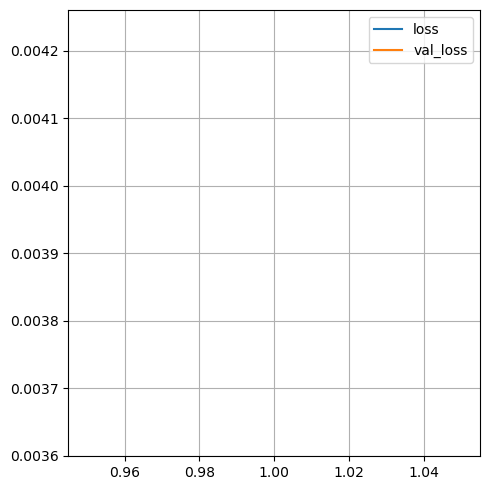

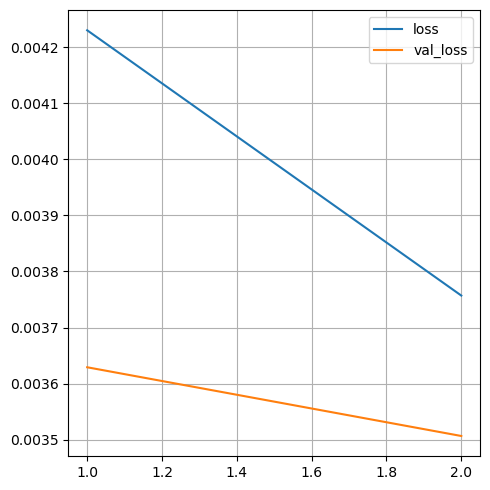

In [6]:
# These will probably have to be commited to yaml
init_lr = 1e-3
seed = random.randint(1000, 9999)
random.seed(seed)
model_name = f'babyFirstRNN_{seed}'
model_path = f'models/{model_name}'

model = rn_network(0,80,2,4, name=model_name) # Format is (type, neurons, number of output features, number of input featues, networkName)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = model_path, save_weights_only=False, verbose=1) # callbacks 
# Compile the model 
adam_optimizer = optimizers.Adam(learning_rate=init_lr)
model.mynn.compile(loss='mse', optimizer=adam_optimizer)
# Train the model 
hist = model.mynn.fit(X_train,y_train, batch_size=1, validation_split=0.15, epochs=2, callbacks = [PlotLearning(), cp_callback], verbose=2)

Save the loss and validation loss as csv files 

In [14]:
complete_loss = pd.DataFrame(hist.history)

with open(f"loss/loss_{model_name}.csv", "wb") as f:
    complete_loss.to_csv(f)


Okay, what does it predict? Make a plot of model predictions vs. ground truths

In [142]:
model_predictions = []

for x in X_test:
    funky = tf.expand_dims(x, axis=0)
    preds = model.mynn.predict(funky, verbose=False)
    model_predictions.append(preds)
    
model_predictions = np.array(model_predictions)

In [143]:
Cn2_pred = model_predictions[:,0,0]
r0_pred = model_predictions[:,0,1]

Cn2_true = y_test[:,0,0]
r0_true = y_test[:,0,1]

Calculate R2 value and make a scatter plot between model predictions and ground truths. If we see something that we can linearly interpolate, then our model is quite powerful

Results on training data
Slope:0.4678458442984128, intercept:0.024983386485533242, r_value:0.3716559298181101
Results on training data
Slope:0.7228080307501804, intercept:0.05891920525291755, r_value:0.3960493298979111


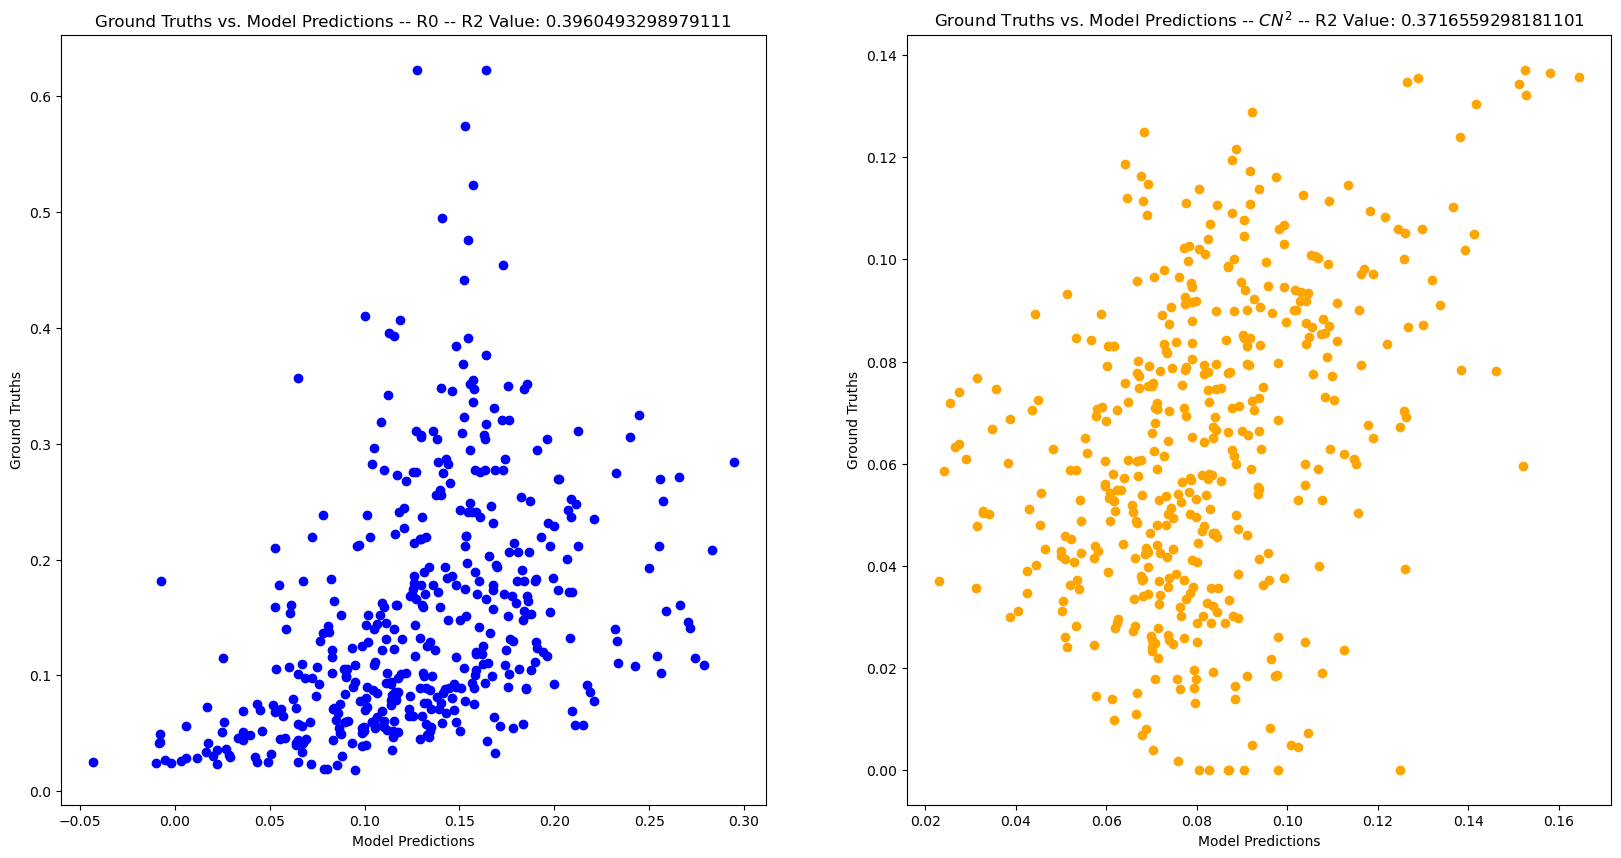

In [144]:
# Compute R2 value

slope_cn, intercept_cn, r_value_cn, p_value_cn, std_err_cn = stats.linregress(Cn2_pred, Cn2_true)

print("Results on training data")
print(f"Slope:{slope_cn}, intercept:{intercept_cn}, r_value:{r_value_cn}")

slope_r0, intercept_r0, r_value_r0, p_value_r0, std_err_r0 = stats.linregress(r0_pred, r0_true)

print("Results on training data")
print(f"Slope:{slope_r0}, intercept:{intercept_r0}, r_value:{r_value_r0}")

fig, ax = plt.subplots(1,2, figsize=(20,10))

ax[0].scatter(r0_pred, r0_true, color='blue')
ax[0].set_xlabel('Model Predictions')
ax[0].set_ylabel('Ground Truths')
ax[0].set_title(f'Ground Truths vs. Model Predictions -- R0 -- R2 Value: {r_value_r0}')

ax[1].scatter(Cn2_pred, Cn2_true, color='orange')
ax[1].set_xlabel('Model Predictions')
ax[1].set_ylabel('Ground Truths')
ax[1].set_title(f'Ground Truths vs. Model Predictions -- $CN^{2}$ -- R2 Value: {r_value_cn}')


plt.show()


# Old

Load up the input and output data & prepare it for training

<Axes: >

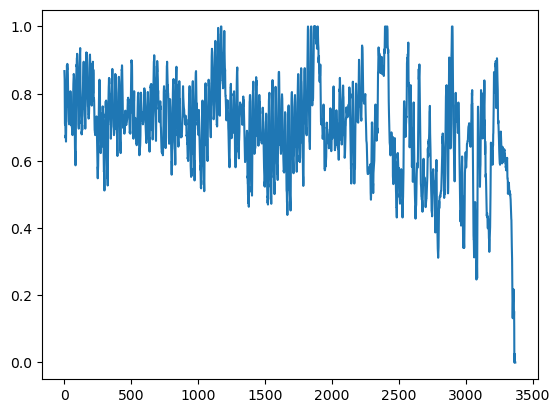

In [97]:
import pandas as pd

# Load csv files 

df_weather=pd.read_csv('Weather Data/input_weatherData.csv')
df_scintillometer=pd.read_csv('Weather Data/output_scintillometerData_wLI.csv')

def loadData(trainPercent): # Mostly plagarized from my QPT training code
    
    temp_input = pd.read_csv('Training Datasets/input_data.csv')
    temp_output = pd.read_csv('Training Datasets/output_data.csv')
    testPercent = 1 - trainPercent
    
    input_data = temp_input.to_numpy()[0:,1:]
    output_data = temp_output.to_numpy()[0:, 1:]
    
    total = len(input_data)
    trainLength = int(trainPercent*total)
    testLength =  int(testPercent*total)
    
    # Create shapes for the training/testing dataset
    
    OGShape_X = np.shape(input_data)
    OGShape_y = np.shape(output_data)
    
    XShape_train = (trainLength, OGShape_X[1])
    yShape_train =  (trainLength, OGShape_y[1])
    
    XShape_test = (testLength, OGShape_X[1])
    yShape_test = (testLength, OGShape_y[1])

    # Instantiate empty lists for the training/test dataset
    
    X_train = np.empty(XShape_train)
    y_train = np.empty(yShape_train)
    
    X_test = np.empty(XShape_test)
    y_test = np.empty(yShape_test)
    
    # Now, activate the indices
    
    X_train = input_data[:trainLength]
    y_train = output_data[:trainLength]
    
    X_test = input_data[trainLength:]
    y_test = output_data[trainLength:]
    

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = loadData(0.85)

# For plotting/visualization ... let's create a time series?

time_series = np.arange(0, len(X_train) )
sns.lineplot(x=time_series, y=X_train[:,0])

Let's make a plot of the data that we're working with 

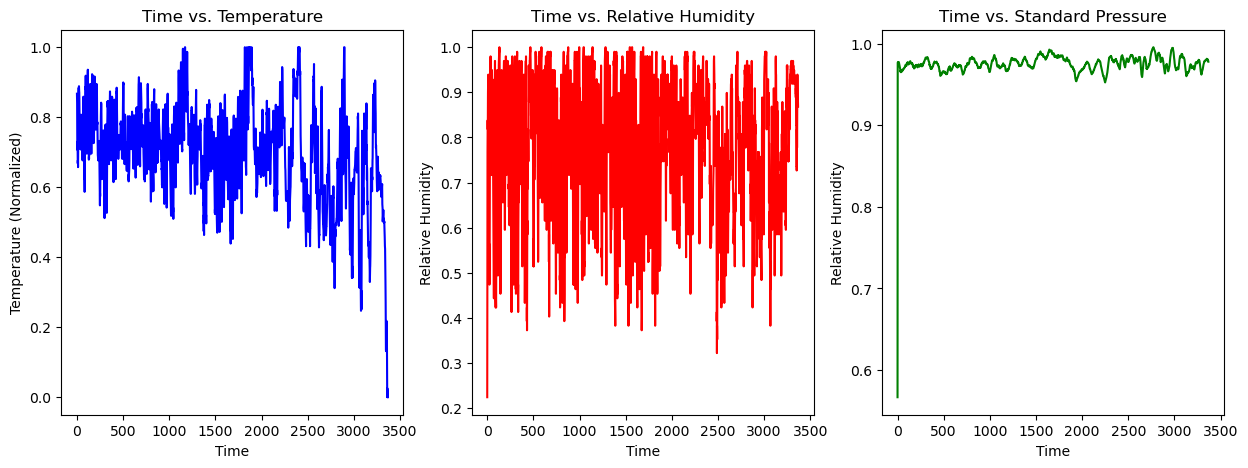

In [98]:
# For plotting/visualization ... let's create a time series? The order of data is Temperature -- Relative Humidity -- Stdn Pressure

time_series = np.arange(0, len(X_train))

fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0] = sns.lineplot(x=time_series, y=X_train[:,0], ax=ax[0], color='blue')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Temperature (Normalized)')
ax[0].set_title('Time vs. Temperature')

ax[1] = sns.lineplot(x=time_series, y=X_train[:,1], ax=ax[1], color='red')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Relative Humidity')
ax[1].set_title('Time vs. Relative Humidity')

ax[2] = sns.lineplot(x=time_series, y=X_train[:,2], ax=ax[2], color='green')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Relative Humidity')
ax[2].set_title('Time vs. Standard Pressure')


plt.show()

In [113]:
x = np.array([1, 2, 3,4,5,6])
# Reshape the input to the required sample_size x time_steps (per batch) x features 
x_input = np.reshape(x,(1, 3, 2))


X_train_input = np.reshape(X_train, (1,len(X_train),3))
X_test_input = np.reshape(X_test, (1,len(X_test),3))

y_train_output = np.reshape(y_train, (1,len(y_train), 2))
y_test_output = np.reshape(y_test, (1,len(y_test), 2))




Yikes ... kinda noisy 

Anyway, let us begin

In [118]:
model = rn_network(0,3,2,3) # LSTM with 20 units and output features of 2

# Compile the model 
model.mynn.compile(loss='mse', optimizer='adam')

# Train the model 
hist = model.mynn.fit(X_train_input,y_train_output, batch_size=1, validation_split=0.15, epochs=30)


Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 0.0671 - val_loss: 0.0542
Epoch 2/30
1/1 [==============================] - 0s 325ms/step - loss: 0.0649 - val_loss: 0.0522
Epoch 3/30
1/1 [==============================] - 0s 320ms/step - loss: 0.0628 - val_loss: 0.0503
Epoch 4/30
1/1 [==============================] - 0s 318ms/step - loss: 0.0608 - val_loss: 0.0483
Epoch 5/30
1/1 [==============================] - 0s 318ms/step - loss: 0.0588 - val_loss: 0.0465
Epoch 6/30
1/1 [==============================] - 0s 319ms/step - loss: 0.0568 - val_loss: 0.0447
Epoch 7/30
1/1 [==============================] - 0s 319ms/step - loss: 0.0549 - val_loss: 0.0430
Epoch 8/30
1/1 [==============================] - 0s 316ms/step - loss: 0.0530 - val_loss: 0.0412
Epoch 9/30
1/1 [==============================] - 0s 329ms/step - loss: 0.0512 - val_loss: 0.0396
Epoch 10/30
1/1 [==============================] - 0s 317ms/step - loss: 0.0494 - val_loss: 0.0380
Epoch 11/30
1/1 [=====